In [51]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import config as cfg
# Load the spreadsheet data into a DataFrame
def load_patient_data(clinical_datapath):
    patientdata = pd.read_excel(clinical_datapath).drop([0,1])
    patientdata["Pat_no"] = patientdata["Pat_no"].astype(int)
    patientdata = patientdata.set_index("Pat_no")
    return patientdata

data = load_patient_data(cfg.CLINICAL_DATA_XL)
feature_lv = ["CMR_LV_mass","CMR_LV_EDV", "CMR_LV_ESV", "CMR_EF",
"CMR_max_ED_thickness_ineferolat_wall","CMR_max_ES_thickness_ineferolat_wall","LA_Volume",
"LVEDD","LVESD","LVPWd","IVSs"]
features = data[feature_lv].fillna(0).to_numpy()

# Create an empty graph
G = nx.Graph()

# Add nodes to the graph with features as node attributes, filling NaN with 0
for pat_no in data.index:
    node_data = {feature: data.loc[pat_no, feature] if not pd.isna(data.loc[pat_no, feature]) else 0 for feature in feature_lv}
    G.add_node(pat_no, **node_data)

G.nodes.data()
data

,ICD_incl,consent,BSA,Gender,age_inclusion,Weight,Height,BMI,syst_BP,diast_BP,...,Amiodarone,Verapamil,Aborted_cardiac_arrest.1,Ventricular_tachycardia.1,nsVT.1,nsVT_study_start.1,Holter_nsVT.1,S_EKG_nsVT.1,NSVT_Holter_stress,Unnamed: 457
Pat_no,,,,,,,,,,,,,,,,,,,,,
3,0.0,1.0,1.59,1.0,66.000000,54.0,1.65,19.8,147.0,91.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
8,0.0,NaN,1.97,0.0,45.000000,75.0,1.83,22.4,129.0,72.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
15,0.0,1.0,2.06,0.0,60.000000,90.0,1.80,27.8,134.0,80.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
17,0.0,1.0,1.52,1.0,66.000000,49.0,1.64,18.2,152.0,82.0,...,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN
19,0.0,1.0,1.76,1.0,76.000000,70.0,1.63,26.3,139.0,79.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,NaN,NaN,NaN,1.0,52.716667,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
220,NaN,NaN,NaN,1.0,25.019444,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
221,NaN,NaN,NaN,1.0,25.002778,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
"Add edges to the graph based on clinical events and arrhythmias"
has_event = data[["Aborted_cardiac_arrest",
                           "Ventricular_tachycardia"]].fillna(0).sum(axis = 1) > 0

any_arrhythmia = data[["Aborted_cardiac_arrest",
                               "Ventricular_tachycardia",
                               "nsVT"]].fillna(0).sum(axis = 1) > 0

data["arrhythmic_composite"] = has_event
data["any_arrhythmia"] = any_arrhythmia
clinical_event = data.loc[data["arrhythmic_composite"]]
clinical_noevent = data.loc[~data["any_arrhythmia"]]
# clinical_event
patient_ev = data[has_event].index

for i in range(len(patient_ev)):
    for j in range(i + 1, len(patient_ev)):
        G.add_edge(patient_ev[i], patient_ev[j])



In [ ]:
" Add edge based on fibrosis "
has_fibrosis= data[["CMR_LGE_Myocardium_percent","CMR_LGE_ANT_Pap_muscle","CMR_LGE_POST_Pap_muscle"]].fillna(0).sum(axis = 1) > 0
data["has_fibrosis"] = has_fibrosis
patient_has_fibrosis = data[has_fibrosis].index
for i in range(len(patient_has_fibrosis)):
    for j in range(i + 1, len(patient_has_fibrosis)):
        G.add_edge(patient_has_fibrosis[i], patient_has_fibrosis[j])


In [17]:
" Add edge based on MVP presence "
has_MVP = data[["MVP_new"]].fillna(0).sum(axis = 1) > 0
data["has_MVP"] =  has_MVP
patient_has_MVP = data[has_MVP].index
for i in range(len(patient_has_MVP)):
    for j in range(i + 1, len(patient_has_MVP)):
        G.add_edge(patient_has_MVP[i], patient_has_MVP[j])
len(patient_has_MVP)

65

In [22]:
"Add edge based on T_inv"
has_T_inv = data[["T_inversions_y_n"]].fillna(0).sum(axis = 1) > 0
data["has_T_inv"] =  has_T_inv
patient_has_T_inv = data[has_T_inv].index
for i in range(len(patient_has_T_inv)):
    for j in range(i + 1, len(patient_has_T_inv)):
        G.add_edge(patient_has_T_inv[i], patient_has_T_inv[j])
"Add edge based on TAD_presence"
has_TAD = data[["TAD_presence"]].fillna(0).sum(axis = 1) > 0
data["has_TAD"] =  has_TAD
patient_has_TAD = data[has_TAD].index
for i in range(len(patient_has_TAD)):
    for j in range(i + 1, len(patient_has_TAD)):
        G.add_edge(patient_has_TAD[i], patient_has_TAD[j])

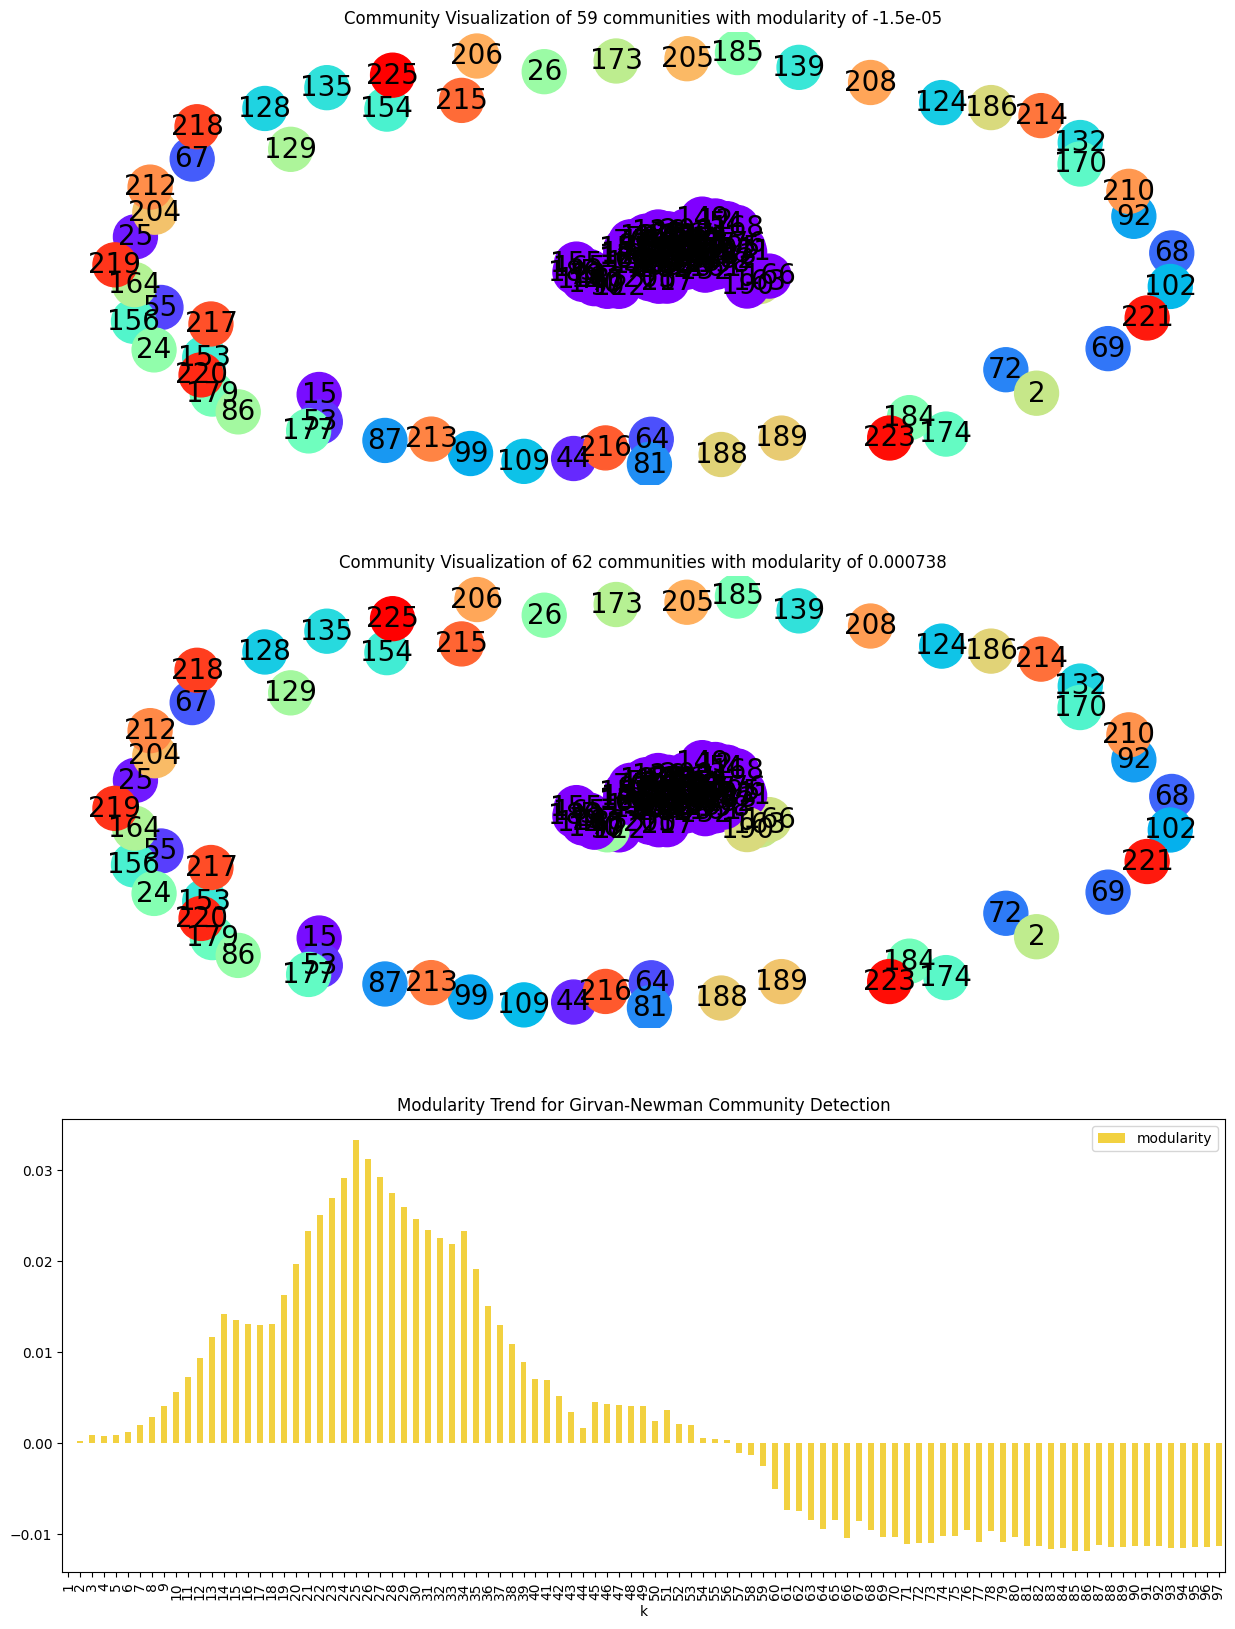

In [26]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


communities = list(nx.community.girvan_newman(G))

# Modularity -> measures the strength of division of a network into modules
modularity_df = pd.DataFrame(
    [
        [k + 1, nx.community.modularity(G, communities[k])]
        for k in range(len(communities))
    ],
    columns=["k", "modularity"],
)


def create_community_node_colors(graph, communities):
    number_of_communities = len(communities)
    colors = cm.rainbow(np.linspace(0, 1, number_of_communities))
    node_colors = []

    for node in graph:
        for i, community in enumerate(communities):
            if node in community:
                node_colors.append(colors[i])
                break

    return node_colors


# function to plot graph with node colouring based on communities
def visualize_communities(graph, communities, i):
    node_colors = create_community_node_colors(graph, communities)
    modularity = round(nx.community.modularity(graph, communities), 6)
    title = f"Community Visualization of {len(communities)} communities with modularity of {modularity}"
    pos = nx.spring_layout(graph, k=0.3, iterations=50, seed=2)
    plt.subplot(3, 1, i)
    plt.title(title)
    nx.draw(
        graph,
        pos=pos,
        node_size=1000,
        node_color=node_colors,
        with_labels=True,
        font_size=20,
        font_color="black",
    )


fig, ax = plt.subplots(3, figsize=(15, 20))

# Plot graph with colouring based on communities
visualize_communities(G, communities[0], 1)
visualize_communities(G, communities[3], 2)

# Plot change in modularity as the important edges are removed
modularity_df.plot.bar(
    x="k",
    ax=ax[2],
    color="#F2D140",
    title="Modularity Trend for Girvan-Newman Community Detection",
)
plt.show()

In [27]:
from sklearn.cluster import spectral_clustering
A = nx.adjacency_matrix(G).toarray()
model = spectral_clustering(A,n_clusters=4,  assign_labels='kmeans')


/Users/giuliamonopoli/miniconda3/envs/pyt_env/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [49]:
import networkx as nx
from sklearn.cluster import SpectralClustering
from sklearn.metrics import pairwise_distances
import numpy as np
feature = ["CMR_LV_mass","CMR_LV_EDV", "CMR_LV_ESV", "CMR_EF",
"CMR_max_ED_thickness_ineferolat_wall","CMR_max_ES_thickness_ineferolat_wall","LA_Volume",
"LVEDD","LVESD","LVPWd","IVSs"]

features = data[feature].fillna(0).to_numpy()

# Assuming `patients_data` is your clinical data where each row is a patient's attributes
similarity_matrix = pairwise_distances(features, metric='euclidean')
similarity_matrix = np.exp(-similarity_matrix ** 2 / (2. * np.std(similarity_matrix) ** 2))

# Create a graph from the similarity matrix
G = nx.from_numpy_array(similarity_matrix)

# Perform spectral clustering
sc = SpectralClustering(4, affinity='precomputed', n_init=100)  # Example for 3 clusters
cluster_labels = sc.fit(similarity_matrix)
cluster_labels = cluster_labels.labels_

# print(cluster_labels)
data['cluster'] = cluster_labels



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [45]:
# Create a dictionary to hold data for all clusters
cluster_data = {}

for i in range(5):
    # Filter data for each cluster
    cluster_data[i] =data[data['cluster'] == i]

    # Display the first few rows of data for each cluster
    print(f"Data for cluster {i}:")
    print(cluster_data[i].head())

Data for cluster 0:
        ICD_incl  consent   BSA  Gender  age_inclusion  Weight  Height   BMI  \
Pat_no                                                                         
15           0.0      1.0  2.06     0.0           60.0    90.0    1.80  27.8   
19           0.0      1.0  1.76     1.0           76.0    70.0    1.63  26.3   
25           0.0      1.0   1.7     1.0           54.0    62.0    1.67  22.2   
27           0.0      1.0  1.89     0.0           77.0    70.0    1.80  21.6   
44           0.0      1.0  1.75     1.0           50.0    65.0    1.70  22.5   

        syst_BP  diast_BP  ...  S_EKG_nsVT.1 NSVT_Holter_stress  Unnamed: 457  \
Pat_no                     ...                                                  
15        134.0      80.0  ...           0.0                0.0           NaN   
19        139.0      79.0  ...           0.0                0.0           NaN   
25        140.0     102.0  ...           0.0                0.0           NaN   
27        136.

In [50]:

average_feature_per_cluster = data.groupby('cluster')[["Leaflet_thickness","MAD_presence","MAD_4CH_length",
    "LVs_mass","EF","LA_Volume","CMR_LV_EDV","CMR_LV_ESV","CMR_ESV","CMR_EF","CMR_LGE_Myocardium_percent","CMR_LGE_ANT_Pap_muscle","CMR_LGE_POST_Pap_muscle","CMR_max_ED_thickness_ineferolat_wall",
     "CMR_max_ES_thickness_ineferolat_wall"]].mean()

# Display the result
print(average_feature_per_cluster)

         Leaflet_thickness  MAD_presence  MAD_4CH_length    LVs_mass  \
cluster                                                                
0                 3.211538      0.962264        4.692308  139.326923   
1                 3.518000      0.960784        4.137255  175.093023   
2                 3.500000      0.785714        4.933333  110.555556   
3                 3.888889      1.000000        4.500000  204.500000   

                EF   LA_Volume  CMR_LV_EDV  CMR_LV_ESV     CMR_ESV  CMR_EF  \
cluster                                                                      
0        55.641509   60.000000  140.018868       103.0   58.836735    45.0   
1        56.372549   83.137255         NaN         NaN   85.250000     NaN   
2        55.166667   28.300000         NaN         NaN  100.333333     NaN   
3        57.944444  118.277778  190.388889         NaN   93.000000     NaN   

         CMR_LGE_Myocardium_percent  CMR_LGE_ANT_Pap_muscle  \
cluster                            